['Retailer01', 'Retailer02', 'Retailer03', 'Retailer04', 'Retailer05', 'Retailer06', 'Retailer07', 'Retailer08'] {'Retailer01': [3, 6, 3, 8, 1, 9, 3, 2, 3, 6, 9, 9, 10, 10, 5, 1, 1, 7, 3, 1, 9, 9, 2, 3, 10, 4, 8, 6, 3, 1, 7, 3, 6, 8, 3, 10, 7, 2, 3, 5, 7, 9, 6, 9, 5, 6, 7, 1, 6, 6, 9, 10, 4, 8, 3, 7, 2, 7, 8, 3, 5, 3, 6, 2, 4, 4, 5, 3, 8, 10, 5, 1, 10, 8, 8, 2, 1, 6, 6, 5, 1, 2, 9, 3, 1, 6, 9, 8, 2, 2, 5, 2, 1, 2, 5, 6, 8, 9, 1, 8, 6, 8, 10, 5, 2, 9, 6, 7, 3, 3, 8, 4, 1, 8, 3, 1, 4, 6, 7, 1, 4, 4, 6, 5, 10, 10, 1, 3, 1, 4, 9, 9, 5, 3, 2, 10, 6, 10, 6, 8, 9, 7, 6, 9, 6, 5, 6, 5, 5, 4, 2, 10, 4, 2, 8, 1, 1, 3, 1, 8, 6, 7, 8, 4, 7, 5, 10, 2, 8, 10, 3, 2, 1, 4, 9, 1, 10, 1, 2, 9, 1, 1, 7, 10, 9, 1, 3, 4, 3, 9, 5, 1, 8, 2, 6, 4, 4, 5, 5, 10, 5, 1, 3, 3, 6, 8, 9, 10, 4, 8, 2, 2, 1, 9, 7, 10, 7, 10, 6, 7, 4, 4, 2, 9, 9, 8, 5, 2, 5, 4, 7, 3, 8, 7, 9, 10, 5, 2, 7, 8, 2, 9, 8, 7, 4, 1, 6, 6, 7, 1, 9, 1, 4, 3, 10, 7, 6, 2, 2, 6, 7, 3, 5, 6, 3, 3, 7, 9, 8, 9, 10, 5, 5, 10, 3, 6, 4, 10, 7, 10, 10, 

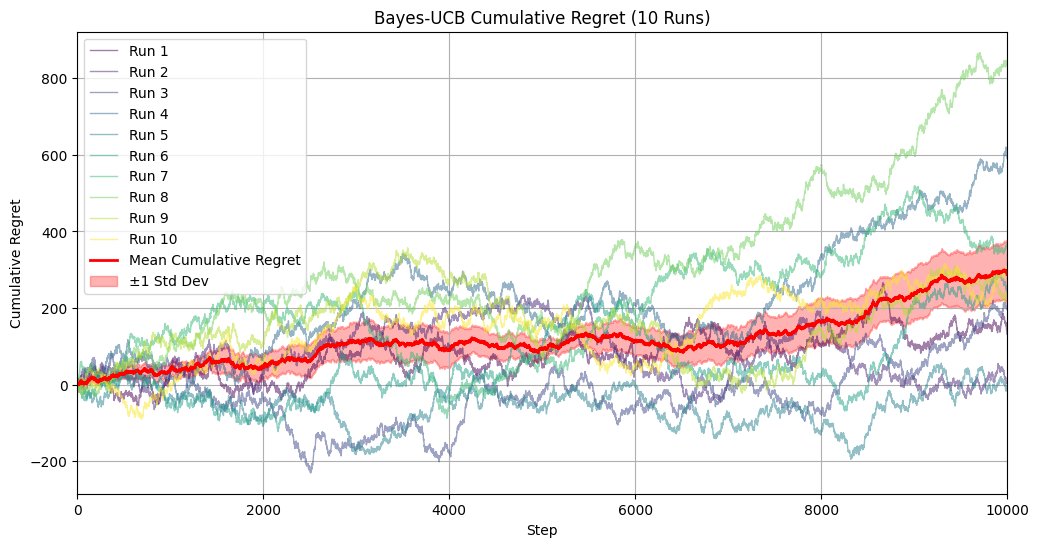

✅ Bayes-UCB total execution time: 94.58 seconds


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os
from joblib import Parallel, delayed
from scipy.stats import norm

# Load preprocessed data
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "rtlr_arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rtlr_rewards.json"), "r") as f:
        rewards = json.load(f)

    all_rewards = [r for reward_list in rewards.values() for r in reward_list]
    max_reward = max(all_rewards)
    min_reward = min(all_rewards)
    B = max_reward - min_reward
    print(arms, rewards, B)
    return arms, rewards, B

# Bayes-UCB strategy
def bayes_ucb(K, n, reward_lists, B, seed_offset=0, quantile=0.95):
    rng = np.random.default_rng(42 + seed_offset)

    action_counts = np.zeros(K)
    empirical_means = np.zeros(K)
    cumulative_regrets = np.zeros(n)

    prior_means = np.zeros(K)
    prior_variances = np.ones(K) * (B**2 / 4)

    true_means = np.array([np.mean(r) for r in reward_lists])
    best_mean = np.max(true_means)

    for t in range(n):
        ucb_values = norm.ppf(quantile, loc=prior_means, scale=np.sqrt(prior_variances))
        arm = np.argmax(ucb_values)
        reward = rng.choice(reward_lists[arm])

        action_counts[arm] += 1
        empirical_means[arm] += (reward - empirical_means[arm]) / action_counts[arm]

        prior_means[arm] = empirical_means[arm]
        prior_variances[arm] = (B**2 / 4) / action_counts[arm]

        regret = best_mean - reward
        cumulative_regrets[t] = regret if t == 0 else cumulative_regrets[t - 1] + regret

    return cumulative_regrets

# Load data
arms, rewards, B = load_preprocessed_data()
reward_lists = list(rewards.values())
K = len(arms)
n = 10000
num_runs = 10

# Start timing
start_time = time.time()

# Run Bayes-UCB
all_cumulative_regrets = Parallel(n_jobs=-1)(
    delayed(bayes_ucb)(K, n, reward_lists, B, seed_offset=i) for i in range(num_runs)
)
all_cumulative_regrets = np.array(all_cumulative_regrets)

# Mean and Std
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = np.std(all_cumulative_regrets, axis=0) / np.sqrt(num_runs)

# Plot
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))
plt.figure(figsize=(12, 6))
for i in range(num_runs):
    plt.plot(all_cumulative_regrets[i], color=colors[i], alpha=0.5, linewidth=1, label=f'Run {i+1}')
plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n),
                 mean_cumulative_regrets - stderr_cumulative_regrets,
                 mean_cumulative_regrets + stderr_cumulative_regrets,
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('Bayes-UCB Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

end_time = time.time()
print(f"✅ Bayes-UCB total execution time: {end_time - start_time:.2f} seconds")





In [ ]:
# Bayes-UCB combines the exploration mechanism of UCB with the precision of Bayesian inference, and is particularly stable when rewards are uncertain or vary little. Your implementation further enhances efficiency, stability, and visualisation capabilities, making it ideal for algorithm baseline comparisons in real-world applications such as recommendation systems.